# A

In [1]:
import pandas as pd
import os

def process_results(path_suffix):
    name = ['1', '2', '3', '4', '5']
    merged_dict = {}
    for i in name:
        dataframes = {
            'ERGO_lstm': pd.read_csv(f"./ERGO/result/pair300/seen/{path_suffix}/{i}_1_1lstm_all_result.csv"),
            'ERGO_AE': pd.read_csv(f"./ERGO/result/pair300/seen/{path_suffix}/{i}_1_1ae_all_result.csv"),
            'NetTCR': pd.read_csv(f"./NetTCR/result/pair300/seen/{path_suffix}/{i}_1_1all_result.csv"),
            'DLpTCR_CNN': pd.read_csv(f"./DLpTCR/result/pair300/seen/{path_suffix}/{i}_1_1CNN_pca20_all_result.csv"),
            'DLpTCR_FULL': pd.read_csv(f"./DLpTCR/result/pair300/seen/{path_suffix}/{i}_1_1FULL_pca18_all_result.csv"),
            'DLpTCR_RESNET': pd.read_csv(f"./DLpTCR/result/pair300/seen/{path_suffix}/{i}_1_1RESNET_pca10_all_result.csv"),
            'AttnTAP': pd.read_csv(f"./AttnTAP/result/pair300/seen/{path_suffix}/{i}_1_1all_result.csv"),
            'ATM_TCR': pd.read_csv(f"./ATM_TCR/result/pair300/seen/{path_suffix}/{i}_1_1all_result.csv"),
            'TEINet': pd.read_csv(f"./TEINet/result/pair300/seen/{path_suffix}/{i}_1_1all_result.csv"),
            'epiTCR': pd.read_csv(f"./epiTCR/result/pair300/seen/{path_suffix}/{i}_1_1all_result.csv"),
            'TCR_BERT': pd.read_csv(f"./tcr_bert/result/pair300/seen/{path_suffix}/{i}_1_1all_result.csv"),
            'TCRGP': pd.read_csv(f"./TCRGP/result/pair300/seen/{path_suffix}/{i}_1_1all_result.csv"),
            'SETE': pd.read_csv(f"./SETE/result/pair300/seen/{path_suffix}/{i}_1_1all_result.csv"),
            'TEIM': pd.read_csv(f"./TEIM/result/pair300/seen/{path_suffix}/{i}_1_1all_result.csv"),
            'TPBTE': pd.read_csv(f"./TPBTE/result/pair300/seen/{path_suffix}/{i}_1_1all_result.csv"),
        }

        merged = pd.DataFrame()
        for df_name, df in dataframes.items():
            last_row = df.tail(1)
            last_row.index = [df_name] 
            merged = pd.concat([merged, last_row])
        merged = merged.iloc[:, 1:] 
        merged_dict[f'merged{i}'] = merged
    merged1, merged2, merged3, merged4, merged5 = (merged_dict[f'merged{i}'] for i in name)
    df_mean = (merged1 + merged2 + merged3 + merged4 + merged5) / 5
    new_column_names = {
        'roc_auc': 'AUROC', 'prc_auc': 'AUPRC', 'accuracy': 'Accuracy',
        'precision': 'Precision', 'recall': 'Recall', 'specificity': 'Specificity',
        'mcc': 'MCC', 'f1': 'F1'}
    df_mean.rename(columns=new_column_names, inplace=True)
    df_std = pd.concat([merged1, merged2, merged3, merged4, merged5]).groupby(level=0).std()
    new_column_names_std = {
        'roc_auc': 'AUROC_std', 'prc_auc': 'AUPRC_std', 'accuracy': 'Accuracy_std',
        'precision': 'Precision_std', 'recall': 'Recall_std', 'specificity': 'Specificity_std',
        'mcc': 'MCC_std', 'f1': 'F1_std'}
    df_std.rename(columns=new_column_names_std, inplace=True)

    df_mean = pd.concat([df_mean, df_std], axis=1)
    all_values = df_mean.sort_values(by='AUPRC', ascending=False)
    all_values.index = all_values.index.str.replace('_', '-')
    new_column_order = [
        'AUROC', 'AUROC_std',
        'AUPRC', 'AUPRC_std',
        'Accuracy', 'Accuracy_std',
        'Precision', 'Precision_std',
        'Recall', 'Recall_std',
        'Specificity', 'Specificity_std',
        'MCC', 'MCC_std',
        'F1', 'F1_std'
    ]
    all_values = all_values[new_column_order]
    all_values = all_values.round(4)
    all_values.rename_axis('models', inplace=True)
    return all_values

def process_model_test(model_name,namel,Dean,suffix):
    ant_file = "./raw_data/antigen_species.csv"
    ant = pd.read_csv(ant_file)
    name = ['1', '2', '3', '4', '5']
    merged_dict = {}
    for i in name:
        df=pd.read_csv(f"./{model_name}/result/pair300/seen/{Dean}/{i}_{suffix}.csv")
        df.rename(columns={'epitope': 'Epitope'}, inplace=True)
        df = pd.merge(df, ant, on='Epitope')
        df = df[['prc_auc', 'antigen_species']]
        df = df.set_index('antigen_species')
        df = df.groupby('antigen_species').mean()
        column_names = {'prc_auc': f'{namel}_prc_auc'}
        df = df.rename(columns=column_names)
        merged_dict[f'merged{i}'] = df

    merged1, merged2, merged3, merged4, merged5 = (merged_dict[f'merged{i}'] for i in name) 
    df_mean = (merged1 + merged2 + merged3 + merged4 + merged5) / 5
    df_mean = df_mean.reindex(sorted(df_mean.columns), axis=1)
    return df_mean

def all_models_result(ratio,Dean,data_test):
    ERGO_AE = process_model_test('ERGO','ERGO_AE',Dean, f'{ratio}ae_all_result')
    ERGO_lstm = process_model_test('ERGO','ERGO_lstm',Dean, f'{ratio}lstm_all_result')
    NetTCR = process_model_test('NetTCR', 'NetTCR',Dean,f'{ratio}all_result')
    DLpTCR_CNN = process_model_test('DLpTCR', 'DLpTCR_CNN',Dean,f'{ratio}CNN_pca20_all_result')
    DLpTCR_FULL = process_model_test('DLpTCR','DLpTCR_FULL',Dean, f'{ratio}FULL_pca18_all_result')
    DLpTCR_RESNET = process_model_test('DLpTCR','DLpTCR_RESNET',Dean, f'{ratio}RESNET_pca10_all_result')
    AttnTAP = process_model_test('AttnTAP','AttnTAP',Dean, f'{ratio}all_result')
    ATM_TCR = process_model_test('ATM_TCR','ATM_TCR', Dean,f'{ratio}all_result')
    TEINet = process_model_test('TEINet','TEINet',Dean, f'{ratio}all_result')
    epiTCR = process_model_test('epiTCR', 'epiTCR',Dean,f'{ratio}all_result')
    SETE = process_model_test('SETE','SETE',Dean,f'{ratio}all_result')
    TEIM = process_model_test('TEIM','TEIM',Dean, f'{ratio}all_result')
    TPBTE  = process_model_test('TPBTE','TPBTE',Dean, f'{ratio}all_result')
    TCR_BERT  = process_model_test('tcr_bert','TCR_BERT',Dean, f'{ratio}all_result')
    TCRGP  = process_model_test('TCRGP','TCRGP',Dean, f'{ratio}all_result')
    all_data = pd.concat([epiTCR, TEINet, ATM_TCR, AttnTAP,DLpTCR_RESNET,DLpTCR_FULL,DLpTCR_CNN,ERGO_AE,ERGO_lstm,SETE,NetTCR,TPBTE,TEIM,TCR_BERT,TCRGP], axis=1)
    selected = all_data.filter(like='prc_auc')
    selected.columns = [col.replace('_prc_auc', '') for col in selected.columns]
    selected=selected.T
    selected.index = selected.index.str.replace('_', '-', regex=False)
    selected = selected.reindex(data_test.index)
    selected = selected.iloc[::-1]
    return selected

def plot_scatter(ax, selected_data, title, show_yticks=True):
    colors = sns.color_palette("RdYlBu", n_colors=256)[::-1]
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
    norm = plt.Normalize(selected_data.min().min(), selected_data.max().max())
    for i, column in enumerate(selected_data.columns):
        x = np.full(selected_data.shape[0], i)
        y = np.arange(selected_data.shape[0])
        sizes = 100 * selected_data[column] / selected_data.max().max()
        color = cmap(norm(selected_data[column]))
        ax.scatter(x, y, s=sizes, color=color)

    ax.set_xticks(np.arange(selected_data.columns.size))
    ax.set_xticklabels(selected_data.columns, rotation=45, ha='right', va='top')
    ax.set_title(title, fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=10)

    if show_yticks:
        ax.set_yticks(np.arange(selected_data.shape[0]))
        ax.set_yticklabels(selected_data.index)
    else:
        ax.set_yticks([])


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

def generate_heatmap_and_scatterplots(path,data_test, file_name_prefix):
    more300 = all_models_result('1_1',f'more300/{path}' , data_test)
    health_300 = all_models_result('1_1', f'300/{path}', data_test)
    health_200 = all_models_result('1_1', f'200/{path}', data_test)
    health_100 = all_models_result('1_1', f'100/{path}', data_test)
    health_10 = all_models_result('1_1', f'10/{path}', data_test)
 

    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['xtick.labelsize'] = 14  
    plt.rcParams['ytick.labelsize'] = 12 
    colors = sns.color_palette("RdYlBu", n_colors=256)[::-1]
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
    
    fig, axs = plt.subplots(1, 6, figsize=(13, 4.4), gridspec_kw={'width_ratios': [2, 2, 2,2,2, 3]})  

    plot_scatter(axs[0], more300, '>300', show_yticks=True)
    plot_scatter(axs[1], health_300, '300', show_yticks=False)
    plot_scatter(axs[2], health_200, '200', show_yticks=False)
    plot_scatter(axs[3], health_100, '100', show_yticks=False)
    plot_scatter(axs[4], health_10, '10', show_yticks=False)

    sns.heatmap(data_test, cmap=cmap, vmin=0, annot=True, fmt=".2f", vmax=data_test.max().max(), ax=axs[5], yticklabels=False)
    axs[5].set_xticks(np.arange(0.5, len(data_test.columns)))
    axs[5].set_xticklabels(data_test.columns, fontsize=10, rotation=45, ha='right', va='top')
    axs[5].set_title('AUPRC', fontsize=10)
    axs[5].set_yticklabels([]) 
    axs[5].set_ylabel('') 
    plt.subplots_adjust(wspace=0.05)
    plt.savefig(f"./All_results/fig/fig4/{file_name_prefix}.pdf", bbox_inches='tight')
    plt.show()


In [2]:
more300=process_results('more300/healthy/')
more300.to_csv("./All_results/data/data3/A_seen_healthy_more300.csv")
health_300=process_results('300/healthy/')
health_300.to_csv("./All_results/data/data3/A_seen_healthy_300.csv")
health_200=process_results('200/healthy/')
health_200.to_csv("./All_results/data/data3/A_seen_healthy_200.csv")
health_100=process_results('100/healthy/')
health_100.to_csv("./All_results/data/data3/A_seen_healthy_100.csv")
health_10=process_results('10/healthy/')
health_10.to_csv("./All_results/data/data3/A_seen_healthy_10.csv")

desired_index = more300.index
health_300 = health_300.reindex(index=desired_index)
health_200 = health_200.reindex(index=desired_index)
health_100 = health_100.reindex(index=desired_index)
health_10 = health_10.reindex(index=desired_index)

all_data_test = pd.concat([more300['AUPRC'], health_300['AUPRC'], health_200['AUPRC'], health_100['AUPRC'],health_10['AUPRC']], axis=1)
all_data_test.columns = ['>300', '300', '200','100','10']
all_data_test['Mean'] = all_data_test.mean(axis=1)
all_data_test = all_data_test.sort_values(by='Mean', ascending=False)
all_data_test = all_data_test.drop(columns=['Mean'])

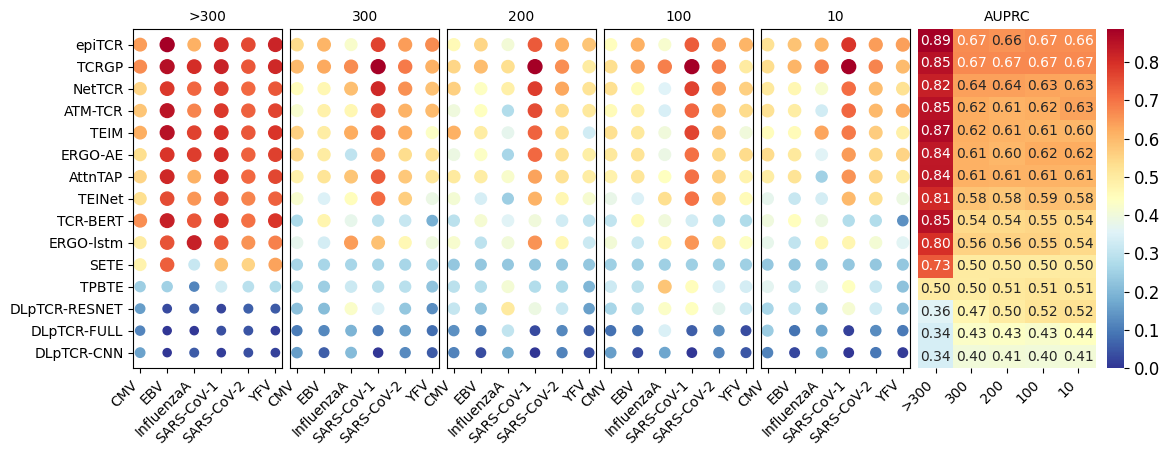

In [3]:
generate_heatmap_and_scatterplots('healthy', all_data_test, "A_seen_moreTCR_health")

# B

/tmp/ipykernel_35465/2306768514.py:66: DtypeWarning: Columns (5,6,7,8,10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("./database/benchmark_dataset/10cross_validation/pair50/healthy/1_1_1train.csv")


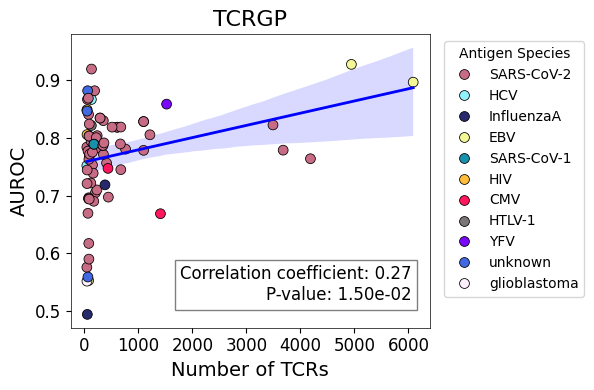

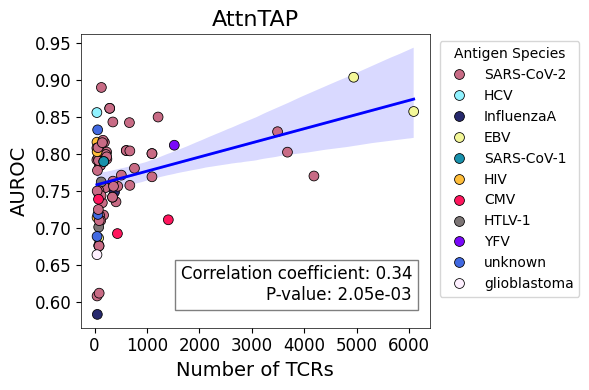

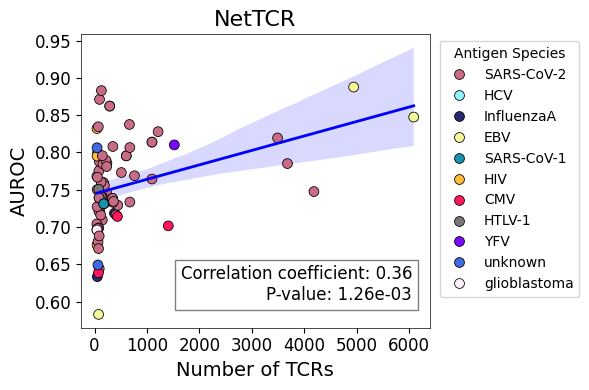

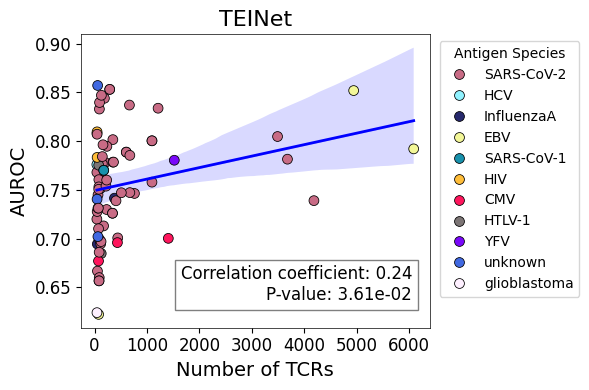

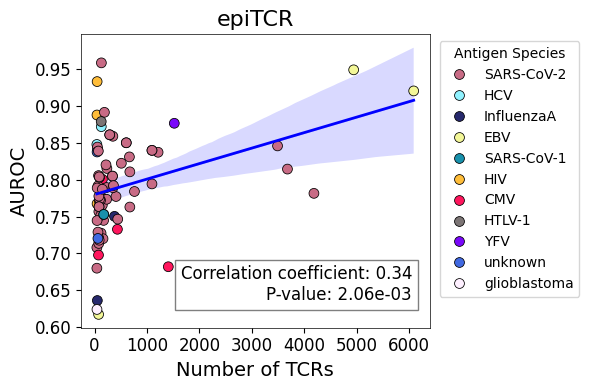

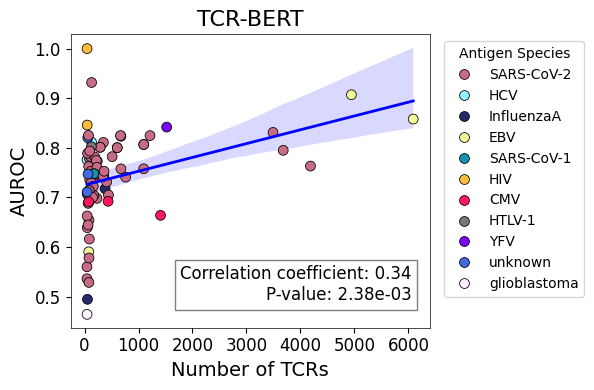

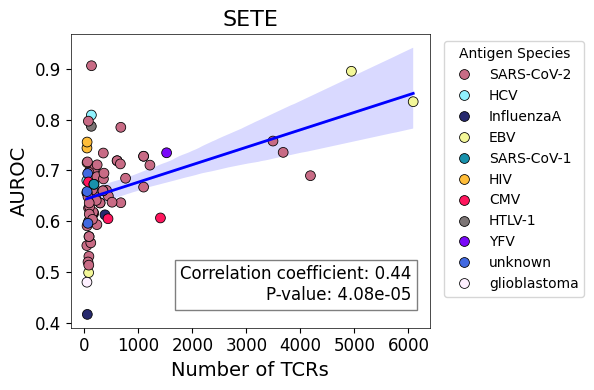

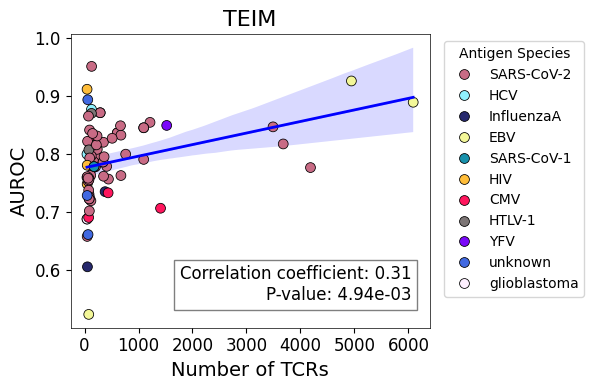

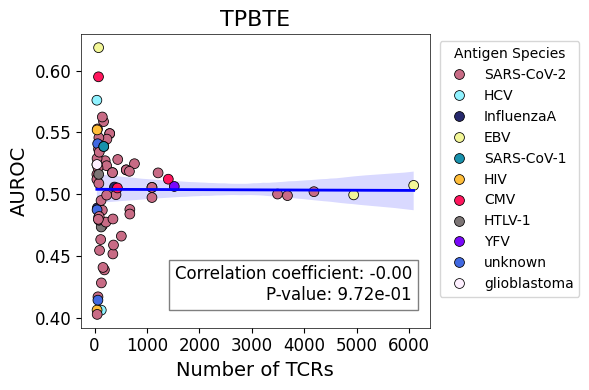

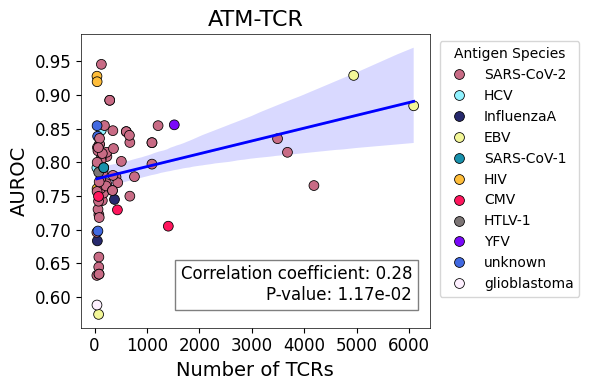

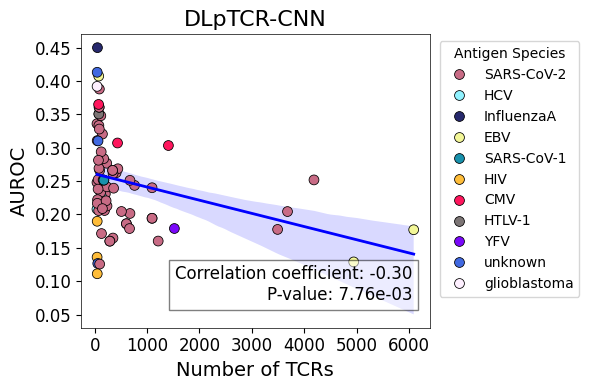

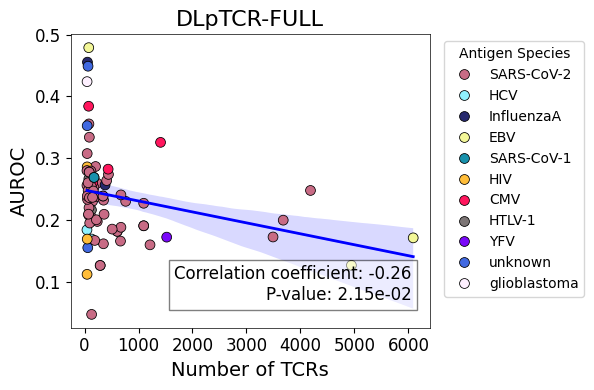

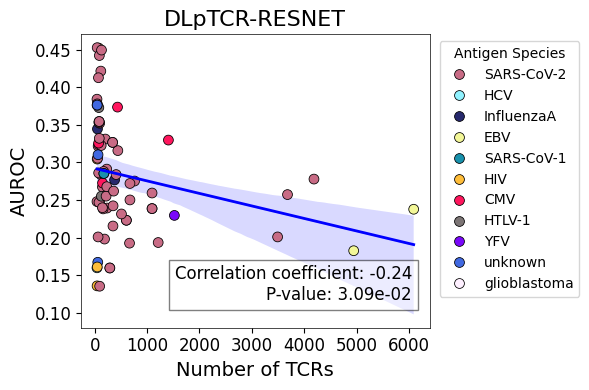

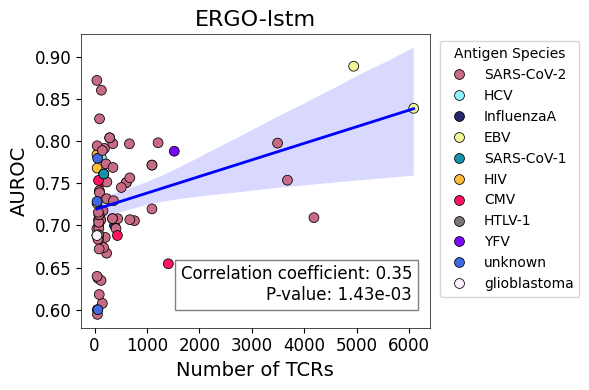

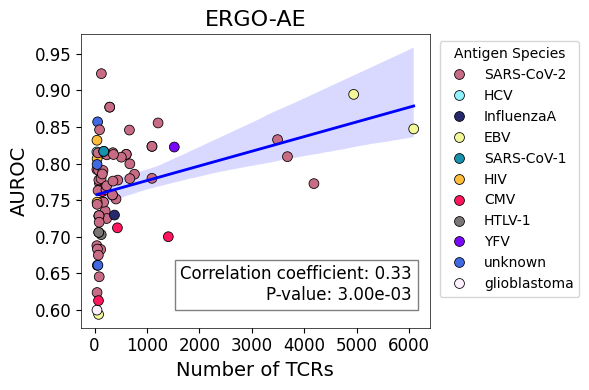

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
import os

def process_and_plot(model_name, base_path, path, data):
    name = ['1', '2', '3', '4', '5']
    merged_dict = {}
    for i in name:
        df = pd.read_csv(f"{base_path}/{i}{path}.csv")
        new_column_names = {
            'roc_auc': 'AUROC', 'prc_auc': 'AUPRC', 'accuracy': 'Accuracy',
            'precision': 'Precision', 'recall': 'Recall', 'specificity': 'Specificity',
            'mcc': 'MCC', 'f1': 'F1'}
        df.rename(columns=new_column_names, inplace=True)
        merged_dict[f'merged{i}'] = df
    merged1, merged2, merged3, merged4, merged5 = (merged_dict[f'merged{i}'] for i in name)
    epitope = merged1['epitope']
    for merged in [merged2, merged3, merged4, merged5]:
        merged['epitope'] = pd.Categorical(merged['epitope'], categories=epitope, ordered=True)
        merged.sort_values('epitope', inplace=True)
    for merged in [merged1, merged2, merged3, merged4, merged5]:
        merged.set_index('epitope', drop=True, inplace=True)
    df_mean = (merged1 + merged2 + merged3 + merged4 + merged5) / 5
    df_mean['Epitope'] = df_mean.index
    df_mean = df_mean.drop(df_mean.tail(1).index)
    data = data[['Epitope', 'count']].drop_duplicates()
    df_merged = pd.merge(df_mean, data, on=['Epitope'])
    antigen = pd.read_csv("./database/benchmark_dataset/raw_data/antigen_species.csv")
    df = pd.merge(df_merged, antigen, on='Epitope')

    slope, intercept, r_value, p_value, std_err = linregress(df['count'], df['AUROC'])
    line_x = np.linspace(df['count'].min(), df['count'].max(), 100)
    line_y = slope * line_x + intercept

    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['axes.edgecolor'] = 'black'
    plt.rcParams['axes.linewidth'] = 0.5
    plt.figure(figsize=(4.5, 4))
    sns.regplot(x='count', y='AUROC', data=df, ci=95, scatter=False,
                line_kws={"color": "blue", "lw": 2})
    colors = ['#c86b85', '#90f2ff', '#27296d', '#f3f798', '#1891ac', '#ffbd39',
          '#ff165d', '#7c7575', '#7a08fa', '#4169E1', '#fef0ff', '#FF8C00', '#4B0082','#20B2AA']
    unique_species = df['antigen_species'].unique()
    species_color_map = {species: colors[i % len(colors)] for i, species in enumerate(unique_species)}
    sns.scatterplot(x='count', y='AUROC', hue='antigen_species', data=df, palette=species_color_map, s=50, edgecolor="black")
    plt.fill_between(line_x, line_y - std_err, line_y + std_err, color="blue", alpha=0.1)
    plt.xlabel('Number of TCRs', fontsize=14)
    plt.ylabel('AUROC', fontsize=14)
    plt.title(f'{model_name}', fontsize=16)
    textstr = f'Correlation coefficient: {r_value:.2f}\nP-value: {p_value:.2e}'
    plt.annotate(textstr, xy=(0.95, 0.08), xycoords='axes fraction', fontsize=12,
                 horizontalalignment='right', verticalalignment='bottom', 
                 bbox=dict(facecolor='white', alpha=0.5))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.grid(False)
    plt.legend(title='Antigen Species', bbox_to_anchor=(1.45, 1), loc='upper right', ncol=1, fontsize=10)
    plt.show()

data = pd.read_csv("./pair50/healthy/1_1_1train.csv")
data = data[data['Affinity'] == 1]
data = data[['CDR3B','Epitope']]
epitope_counts = data['Epitope'].value_counts()
data['count'] = data['Epitope'].map(epitope_counts)

process_and_plot('TCRGP', "./TCRGP/result/pair50/seen/test/healthy",'_1_1all_result', data)
process_and_plot('AttnTAP', "./AttnTAP/result/pair50/seen/test/healthy",'_1_1all_result', data)
process_and_plot('NetTCR', "./NetTCR/result/pair50/seen/test/healthy",'_1_1all_result', data)
process_and_plot('TEINet', "./TEINet/result/pair50/seen/test/healthy",'_1_1all_result', data)
process_and_plot('epiTCR', "./epiTCR/result/pair50/seen/test/healthy", '_1_1all_result',data)
process_and_plot('TCR-BERT', "./tcr_bert/result/pair50/seen/test/healthy", '_1_1all_result',data)
process_and_plot('SETE', "./SETE/result/pair50/seen/test/healthy",'_1_1all_result', data)
process_and_plot('TEIM', "./TEIM/result/pair50/seen/test/healthy", '_1_1all_result',data)
process_and_plot('TPBTE', "./TPBTE/result/pair50/seen/test/healthy", '_1_1all_result',data)
process_and_plot('ATM-TCR', "./ATM_TCR/result/pair50/seen/test/healthy", '_1_1all_result',data)

process_and_plot('DLpTCR-CNN', "./DLpTCR/result/pair50/seen/test/healthy", '_1_1CNN_pca20_all_result',data)
process_and_plot('DLpTCR-FULL', "./DLpTCR/result/pair50/seen/test/healthy", '_1_1FULL_pca18_all_result',data)
process_and_plot('DLpTCR-RESNET', "./DLpTCR/result/pair50/seen/test/healthy", '_1_1RESNET_pca10_all_result',data)
process_and_plot('ERGO-lstm', "./ERGO/result/pair50/seen/test/healthy", '_1_1lstm_all_result',data)
process_and_plot('ERGO-AE', "./ERGO/result/pair50/seen/test/healthy", '_1_1ae_all_result',data)

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
import os
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as mtick  
from matplotlib.ticker import LinearLocator 


pdf_filename = "./All_results/fig/fig4/B_Correlation_TCR_number_AUPRC.pdf"
pdf_pages = PdfPages(pdf_filename)

def process_and_plot(model_name, base_path, path, data):
    name = ['1', '2', '3', '4', '5']
    merged_dict = {}
    for i in name:
        df = pd.read_csv(f"{base_path}/{i}{path}.csv")
        new_column_names = {
            'roc_auc': 'AUROC', 'prc_auc': 'AUPRC', 'accuracy': 'Accuracy',
            'precision': 'Precision', 'recall': 'Recall', 'specificity': 'Specificity',
            'mcc': 'MCC', 'f1': 'F1'}
        df.rename(columns=new_column_names, inplace=True)
        merged_dict[f'merged{i}'] = df
    merged1, merged2, merged3, merged4, merged5 = (merged_dict[f'merged{i}'] for i in name)
    epitope = merged1['epitope']
    for merged in [merged2, merged3, merged4, merged5]:
        merged['epitope'] = pd.Categorical(merged['epitope'], categories=epitope, ordered=True)
        merged.sort_values('epitope', inplace=True)
    for merged in [merged1, merged2, merged3, merged4, merged5]:
        merged.set_index('epitope', drop=True, inplace=True)
    df_mean = (merged1 + merged2 + merged3 + merged4 + merged5) / 5
    df_mean['Epitope'] = df_mean.index
    df_mean = df_mean.drop(df_mean.tail(1).index)
    data = data[['Epitope', 'count']].drop_duplicates()
    df_merged = pd.merge(df_mean, data, on=['Epitope'])
    antigen = pd.read_csv("./database/benchmark_dataset/raw_data/antigen_species.csv")
    df = pd.merge(df_merged, antigen, on='Epitope')

    slope, intercept, r_value, p_value, std_err = linregress(df['count'], df['AUROC'])
    line_x = np.linspace(df['count'].min(), df['count'].max(), 100)
    line_y = slope * line_x + intercept

    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['axes.edgecolor'] = 'black'
    plt.rcParams['axes.linewidth'] = 0.5
    plt.figure(figsize=(4.5, 4))
    sns.regplot(x='count', y='AUROC', data=df, ci=95, scatter=False,
                line_kws={"color": "blue", "lw": 2})
    colors = ['#c86b85', '#90f2ff', '#27296d', '#f3f798', '#1891ac', '#ffbd39',
          '#ff165d', '#7c7575', '#7a08fa', '#4169E1', '#fef0ff', '#FF8C00', '#4B0082','#20B2AA']
    unique_species = df['antigen_species'].unique()
    species_color_map = {species: colors[i % len(colors)] for i, species in enumerate(unique_species)}
    sns.scatterplot(x='count', y='AUROC', hue='antigen_species', data=df, palette=species_color_map, s=50, edgecolor="black")
    plt.fill_between(line_x, line_y - std_err, line_y + std_err, color="blue", alpha=0.1)

    plt.xlabel('Number of TCRs', fontsize=14)
    plt.ylabel('AUROC', fontsize=14)
    plt.gca().yaxis.set_major_locator(LinearLocator(numticks=6))
    plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))

    plt.title(f'{model_name}', fontsize=16)
    textstr = f'Correlation coefficient: {r_value:.2f}\nP-value: {p_value:.2e}'
    plt.annotate(textstr, xy=(0.95, 0.08), xycoords='axes fraction', fontsize=12,
                 horizontalalignment='right', verticalalignment='bottom', 
                 bbox=dict(facecolor='white', alpha=0.5))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.grid(False)
    plt.legend(title='Antigen Species', bbox_to_anchor=(1.45, 1), loc='upper right', ncol=1, fontsize=10)
    pdf_pages.savefig()
    plt.close()

data = pd.read_csv("./pair50/healthy/1_1_1train.csv")
data = data[data['Affinity'] == 1]
data = data[['CDR3B','Epitope']]
epitope_counts = data['Epitope'].value_counts()
data['count'] = data['Epitope'].map(epitope_counts)

model_paths = [
    ('TCRGP', "./TCRGP/result/pair50/seen/test/healthy",'_1_1all_result'),
    ('AttnTAP', "./AttnTAP/result/pair50/seen/test/healthy",'_1_1all_result'),
    ('ATM_TCR', "./ATM_TCR/result/pair50/seen/test/healthy",'_1_1all_result'),
    ('NetTCR', "./NetTCR/result/pair50/seen/test/healthy",'_1_1all_result'),
    ('TEINet', "./TEINet/result/pair50/seen/test/healthy",'_1_1all_result'),
    ('epiTCR', "./epiTCR/result/pair50/seen/test/healthy", '_1_1all_result'),
    ('TCR-BERT', "./tcr_bert/result/pair50/seen/test/healthy", '_1_1all_result'),
    ('SETE', "./SETE/result/pair50/seen/test/healthy",'_1_1all_result'),
    ('TEIM', "./TEIM/result/pair50/seen/test/healthy", '_1_1all_result'),
    ('TPBTE', "./TPBTE/result/pair50/seen/test/healthy", '_1_1all_result'),
    ('DLpTCR-CNN', "./DLpTCR/result/pair50/seen/test/healthy", '_1_1CNN_pca20_all_result'),
    ('DLpTCR-FULL', "./DLpTCR/result/pair50/seen/test/healthy", '_1_1FULL_pca18_all_result'),
    ('DLpTCR-RESNET', "./DLpTCR/result/pair50/seen/test/healthy", '_1_1RESNET_pca10_all_result'),
    ('ERGO-lstm', "./ERGO/result/pair50/seen/test/healthy", '_1_1lstm_all_result'),
    ('ERGO-AE', "./ERGO/result/pair50/seen/test/healthy", '_1_1ae_all_result')]

for model_name, base_path, path in model_paths:
    process_and_plot(model_name, base_path, path, data)

pdf_pages.close()


/tmp/ipykernel_35465/3343964119.py:82: DtypeWarning: Columns (5,6,7,8,10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("./database/benchmark_dataset/10cross_validation/pair50/healthy/1_1_1train.csv")


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
import os
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as mtick  
from matplotlib.ticker import LinearLocator, FormatStrFormatter, MultipleLocator


pdf_filename = "./All_results/fig/fig4/B_Correlation_TCR_number_AUPRC.pdf"
pdf_pages = PdfPages(pdf_filename)

def process_and_plot(model_name, base_path, path, data):
    name = ['1', '2', '3', '4', '5']
    merged_dict = {}
    for i in name:
        df = pd.read_csv(f"{base_path}/{i}{path}.csv")
        new_column_names = {
            'roc_auc': 'AUROC', 'prc_auc': 'AUPRC', 'accuracy': 'Accuracy',
            'precision': 'Precision', 'recall': 'Recall', 'specificity': 'Specificity',
            'mcc': 'MCC', 'f1': 'F1'}
        df.rename(columns=new_column_names, inplace=True)
        merged_dict[f'merged{i}'] = df
    merged1, merged2, merged3, merged4, merged5 = (merged_dict[f'merged{i}'] for i in name)
    epitope = merged1['epitope']
    for merged in [merged2, merged3, merged4, merged5]:
        merged['epitope'] = pd.Categorical(merged['epitope'], categories=epitope, ordered=True)
        merged.sort_values('epitope', inplace=True)
    for merged in [merged1, merged2, merged3, merged4, merged5]:
        merged.set_index('epitope', drop=True, inplace=True)
    df_mean = (merged1 + merged2 + merged3 + merged4 + merged5) / 5
    df_mean['Epitope'] = df_mean.index
    df_mean = df_mean.drop(df_mean.tail(1).index)
    data = data[['Epitope', 'count']].drop_duplicates()
    df_merged = pd.merge(df_mean, data, on=['Epitope'])
    antigen = pd.read_csv("./database/benchmark_dataset/raw_data/antigen_species.csv")
    df = pd.merge(df_merged, antigen, on='Epitope')

    slope, intercept, r_value, p_value, std_err = linregress(df['count'], df['AUROC'])
    line_x = np.linspace(df['count'].min(), df['count'].max(), 100)
    line_y = slope * line_x + intercept

    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['axes.edgecolor'] = 'black'
    plt.rcParams['axes.linewidth'] = 0.5
    plt.figure(figsize=(4.5, 4))
    sns.regplot(x='count', y='AUROC', data=df, ci=95, scatter=False,
                line_kws={"color": "blue", "lw": 2})
    colors = ['#c86b85', '#90f2ff', '#27296d', '#f3f798', '#1891ac', '#ffbd39',
          '#ff165d', '#7c7575', '#7a08fa', '#4169E1', '#fef0ff', '#FF8C00', '#4B0082','#20B2AA']
    unique_species = df['antigen_species'].unique()
    species_color_map = {species: colors[i % len(colors)] for i, species in enumerate(unique_species)}
    sns.scatterplot(x='count', y='AUROC', hue='antigen_species', data=df, palette=species_color_map, s=50, edgecolor="black")
    plt.fill_between(line_x, line_y - std_err, line_y + std_err, color="blue", alpha=0.1)

    plt.xlabel('Number of TCRs', fontsize=14)
    plt.ylabel('AUROC', fontsize=14)
    
    # 设置y轴显示6个刻度
    plt.gca().yaxis.set_major_locator(LinearLocator(numticks=6))
    plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    
    # 设置x轴为 0, 1000, 2000, 3000, 4000, 5000, 6000
    plt.gca().xaxis.set_major_locator(MultipleLocator(1000))
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

    plt.title(f'{model_name}', fontsize=16)
    textstr = f'Correlation coefficient: {r_value:.2f}\nP-value: {p_value:.2e}'
    plt.annotate(textstr, xy=(0.95, 0.08), xycoords='axes fraction', fontsize=12,
                 horizontalalignment='right', verticalalignment='bottom', 
                 bbox=dict(facecolor='white', alpha=0.5))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.grid(False)
    plt.legend(title='Antigen Species', bbox_to_anchor=(1.6, 1), loc='upper right', ncol=1, fontsize=10)
    pdf_pages.savefig()
    plt.close()

data = pd.read_csv("./pair50/healthy/1_1_1train.csv")
data = data[data['Affinity'] == 1]
data = data[['CDR3B','Epitope']]
epitope_counts = data['Epitope'].value_counts()
data['count'] = data['Epitope'].map(epitope_counts)

model_paths = [
    ('TCRGP', "./TCRGP/result/pair50/seen/test/healthy",'_1_1all_result'),
    ('AttnTAP', "./AttnTAP/result/pair50/seen/test/healthy",'_1_1all_result'),
    ('ATM_TCR', "./ATM_TCR/result/pair50/seen/test/healthy",'_1_1all_result'),
    ('NetTCR', "./NetTCR/result/pair50/seen/test/healthy",'_1_1all_result'),
    ('TEINet', "./TEINet/result/pair50/seen/test/healthy",'_1_1all_result'),
    ('epiTCR', "./epiTCR/result/pair50/seen/test/healthy", '_1_1all_result'),
    ('TCR-BERT', "./tcr_bert/result/pair50/seen/test/healthy", '_1_1all_result'),
    ('SETE', "./SETE/result/pair50/seen/test/healthy",'_1_1all_result'),
    ('TEIM', "./TEIM/result/pair50/seen/test/healthy", '_1_1all_result'),
    ('TPBTE', "./TPBTE/result/pair50/seen/test/healthy", '_1_1all_result'),
    ('DLpTCR-CNN', "./DLpTCR/result/pair50/seen/test/healthy", '_1_1CNN_pca20_all_result'),
    ('DLpTCR-FULL', "./DLpTCR/result/pair50/seen/test/healthy", '_1_1FULL_pca18_all_result'),
    ('DLpTCR-RESNET', "./DLpTCR/result/pair50/seen/test/healthy", '_1_1RESNET_pca10_all_result'),
    ('ERGO-lstm', "./ERGO/result/pair50/seen/test/healthy", '_1_1lstm_all_result'),
    ('ERGO-AE', "./ERGO/result/pair50/seen/test/healthy", '_1_1ae_all_result')]

for model_name, base_path, path in model_paths:
    process_and_plot(model_name, base_path, path, data)

pdf_pages.close()


/tmp/ipykernel_11135/1104976055.py:84: DtypeWarning: Columns (5,6,7,8,10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("./database/benchmark_dataset/10cross_validation/pair50/healthy/1_1_1train.csv")


# C

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def plot_epitope_graph(model_name, file_name_prefix):
    data = pd.read_csv(f"./All_results/data/data3/C_max_{model_name}.csv")
    data = data.drop(columns=['Unnamed: 0'])
    average_values = data.iloc[:, 1:].mean()
    data.loc[len(data)] = ['Average'] + average_values.tolist()
    markers = ['o', '^', 's', 'p', '*', '+', 'x', 'D', 'H', '<', '>']
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['font.size'] = 7
    plt.rcParams['xtick.labelsize'] = 7  
    plt.rcParams['ytick.labelsize'] = 7 
    plt.figure(figsize=(3.5, 3.5))
    x = [50, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000]
    color_cycle = plt.cm.tab20.colors
    for i, row in data.iterrows():
        if row['epitope'] == 'Average':
            plt.plot(x, row[1:], label=row['epitope'], marker='o', color='red', linewidth=2) 
        else:
            marker = markers[i % len(markers)]
            color = color_cycle[i % len(color_cycle)] 
            plt.plot(x, row[1:], label=row['epitope'], marker=marker, color=color, linestyle='--', linewidth=1, alpha=0.7)  # 使用浅色和虚线
    plt.legend()
    plt.xlabel('Number of TCRs')
    plt.ylabel('AUPRC ')
    plt.xticks(ticks=x, labels=x, rotation=45, fontsize=7, ha='center')
    plt.ylim(0.5, 1)
    plt.title(f'{model_name}')
    plt.tight_layout()
    plt.savefig(f"./All_results/fig/fig4/{file_name_prefix}.pdf", bbox_inches='tight')
    plt.show()
    return data


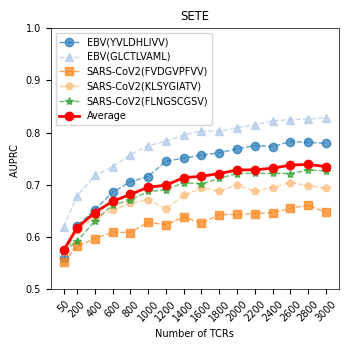

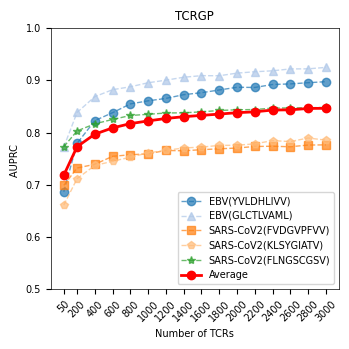

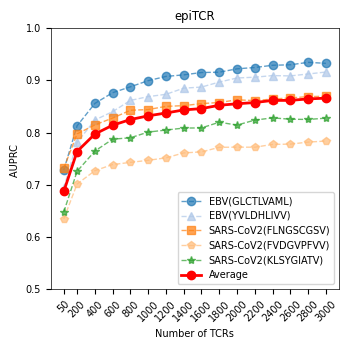

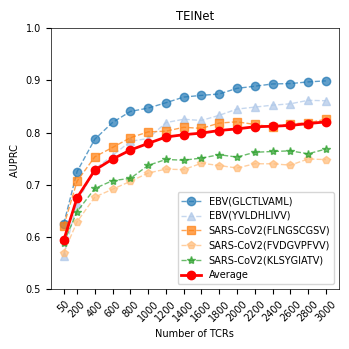

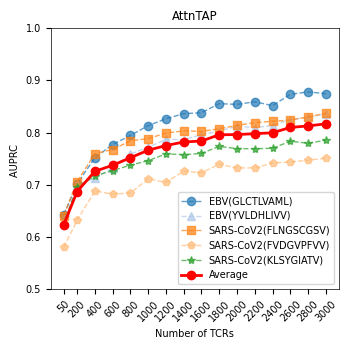

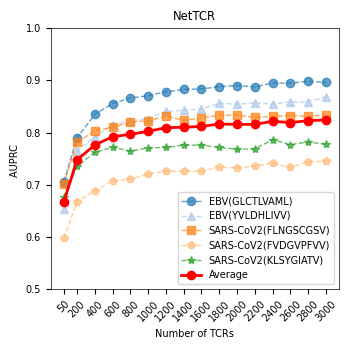

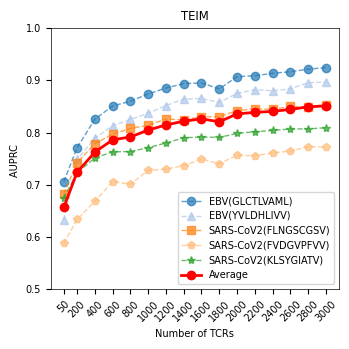

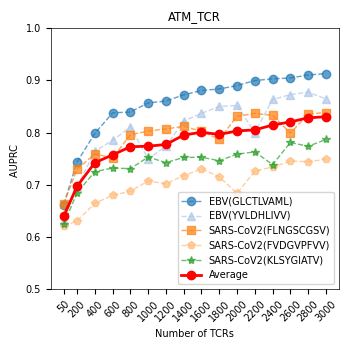

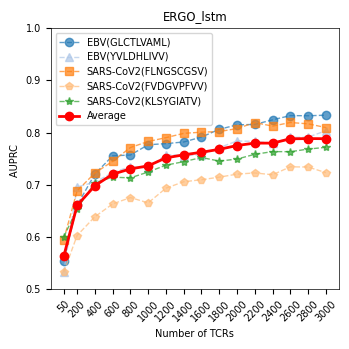

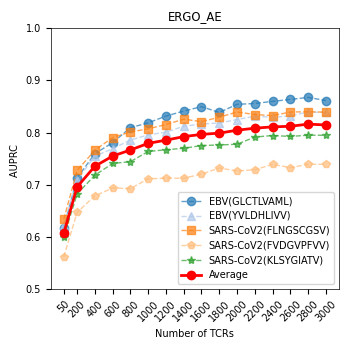

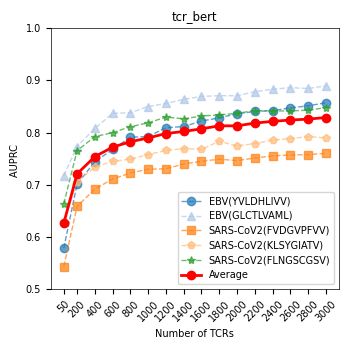

In [4]:
SETE=plot_epitope_graph('SETE','C_max_top5_SETE')
TCRGP=plot_epitope_graph('TCRGP','C_max_top5_TCRGP')
epiTCR=plot_epitope_graph('epiTCR','C_max_top5_epiTCR')
TEINet=plot_epitope_graph('TEINet','C_max_top5_TEINet')
AttnTAP=plot_epitope_graph('AttnTAP','C_max_top5_AttnTAP')
NetTCR=plot_epitope_graph('NetTCR','C_max_top5_NetTCR')
TEIM=plot_epitope_graph('TEIM','C_max_top5_TEIM')
ATM_TCR=plot_epitope_graph('ATM_TCR','C_max_top5_ATM_TCR')
ERGO_lstm=plot_epitope_graph('ERGO_lstm','C_max_top5_ERGO_lstm')
ERGO_ae=plot_epitope_graph('ERGO_AE','C_max_top5_ERGO_ae')
tcr_bert=plot_epitope_graph('tcr_bert','C_max_top5_tcr_bert')

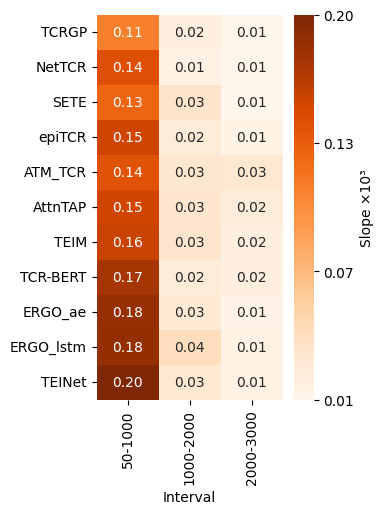

In [16]:
#斜率
dataframes = {'SETE': SETE, 'TCRGP': TCRGP,'epiTCR': epiTCR, 'TEINet': TEINet, 
              'NetTCR': NetTCR, 'TEIM': TEIM, 'ATM_TCR': ATM_TCR,'ERGO_lstm':ERGO_lstm,
              'ERGO_ae':ERGO_ae,'AttnTAP':AttnTAP,'TCR-BERT':tcr_bert}
last_rows = {}
for name, df in dataframes.items():
    last_rows[name] = df.iloc[-1]
new_df = pd.DataFrame(last_rows).T
new_df = new_df.drop(columns=['epitope'])
import seaborn as sns
import numpy as np
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.size'] = 10
plt.rcParams['xtick.labelsize'] = 10  
plt.rcParams['ytick.labelsize'] = 10 
intervals = [(50, 1000),(1000, 2000), (2000, 3000)]
new_df.columns = new_df.columns.astype(str)
slope_df = pd.DataFrame(index=new_df.index, columns=[f"{start}-{end}" for start, end in intervals])
for start, end in intervals:
    slope_df[f"{start}-{end}"] = (new_df[str(end)] - new_df[str(start)]) / (end - start)
slope_df = slope_df.astype(float)
slope_df=slope_df*1000
slope_df['Average'] = slope_df.mean(axis=1)
slope_df = slope_df.sort_values(by='Average', ascending=True)
slope_df = slope_df.drop(columns=['Average'])
slope_df = slope_df.round(3)
plt.figure(figsize=(3, 5))
ax = sns.heatmap(slope_df, annot=True, cmap='Oranges', fmt=".2f", cbar_kws={'label':'Slope ×10³'})
colorbar = ax.collections[0].colorbar
colorbar.set_ticks(np.linspace(slope_df.min().min(), slope_df.max().max(), num=4))
colorbar.set_ticklabels([f'{x:.2f}' for x in np.linspace(slope_df.min().min(), slope_df.max().max(), num=4)])
#plt.title('Model Performance Slope across Different TCR Number Intervals')
plt.xlabel('Interval')
plt.savefig("./All_results/fig/fig4/C_Average_AUPRC_of_All_Models_Slope.pdf", bbox_inches='tight')
plt.show()


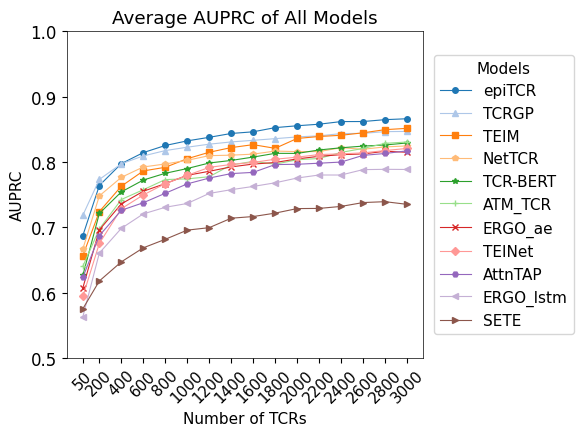

In [15]:
new_df['mean'] = new_df.mean(axis=1)
new_df_sorted = new_df.sort_values(by='mean', ascending=False).drop(columns='mean')
markers = ['o', '^', 's', 'p', '*', '+', 'x', 'D', 'H', '<', '>']
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.size'] = 11
plt.rcParams['xtick.labelsize'] = 12  
plt.rcParams['ytick.labelsize'] = 12 
plt.figure(figsize=(6, 4.5))
x = [50, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000]
color_cycle = plt.cm.tab20.colors
for i, (model_name, row) in enumerate(new_df_sorted.iterrows()):
    marker = markers[i % len(markers)]
    color = color_cycle[i % len(color_cycle)]
    plt.plot(x, row, label=model_name, marker=marker, color=color, linestyle='-', linewidth=0.8, markersize=4)
plt.legend(bbox_to_anchor=(1.03, 0.5), loc='center left', borderaxespad=0., title="Models")
plt.xlabel('Number of TCRs')
plt.ylabel('AUPRC')
plt.xticks(ticks=x, labels=x, rotation=45, fontsize=11, ha='center')
plt.ylim(0.5, 1)
plt.title('Average AUPRC of All Models')
plt.tight_layout()
plt.savefig("./All_results/fig/fig4/C_Average_AUPRC_of_All_Models.pdf", bbox_inches='tight')
plt.show()


# D

In [31]:
def process(model_name, base_path, file_suffix):
    name = ['1', '2', '3', '4', '5']
    merged_dict = {}
    for i in name:
        file_path = f"{base_path}/{i}{file_suffix}.csv"
        df = pd.read_csv(file_path)
        df.rename(columns={'epitope': 'Epitope'}, inplace=True)
        df = df.drop(df.index[-1], axis=0) 
        df = df[['Epitope', 'prc_auc']]
        df.index = df['Epitope']
        df = df[['prc_auc']]
        merged_dict[f'merged{i}'] = df
    
    merged1, merged2, merged3, merged4, merged5 = (merged_dict[f'merged{i}'] for i in name)
    dfs = [merged1, merged2, merged3, merged4, merged5]
    df_all = pd.concat(dfs, axis=1)
    df_all[f'{model_name}'] = df_all.mean(axis=1)
    result = df_all[[f'{model_name}']]
    return result

TCRGP =process('TCRGP', "./TCRGP/result/pair50/seen/test/healthy",'_1_1all_result')
AttnTAP=process('AttnTAP', "./AttnTAP/result/pair50/seen/test/healthy",'_1_1all_result')
ATM_TCR=process('ATM-TCR', "./ATM_TCR/result/pair50/seen/test/healthy",'_1_1all_result')
NetTCR=process('NetTCR', "./NetTCR/result/pair50/seen/test/healthy",'_1_1all_result')
TEINet=process('TEINet', "./TEINet/result/pair50/seen/test/healthy",'_1_1all_result')
epiTCR=process('epiTCR', "./epiTCR/result/pair50/seen/test/healthy", '_1_1all_result')
TCR_BERT=process('TCR-BERT', "./tcr_bert/result/pair50/seen/test/healthy", '_1_1all_result')
SETE=process('SETE', "./SETE/result/pair50/seen/test/healthy",'_1_1all_result')
TEIM=process('TEIM', "./TEIM/result/pair50/seen/test/healthy", '_1_1all_result')
TPBTE=process('TPBTE', "./TPBTE/result/pair50/seen/test/healthy", '_1_1all_result')
DLpTCR_CNN=process('DLpTCR-CNN', "./DLpTCR/result/pair50/seen/test/healthy", '_1_1CNN_pca20_all_result')
DLpTCR_FULL=process('DLpTCR-FULL', "./DLpTCR/result/pair50/seen/test/healthy", '_1_1FULL_pca18_all_result')
DLpTCR_RESNET=process('DLpTCR-RESNET', "./DLpTCR/result/pair50/seen/test/healthy", '_1_1RESNET_pca10_all_result')
ERGO_lstm=process('ERGO-lstm', "./ERGO/result/pair50/seen/test/healthy", '_1_1lstm_all_result')
ERGO_AE=process('ERGO-AE', "./ERGO/result/pair50/seen/test/healthy", '_1_1ae_all_result')


In [32]:
df_list = [TCRGP, AttnTAP, ATM_TCR, NetTCR, TEINet, epiTCR, TCR_BERT, 
    SETE, TEIM, TPBTE, DLpTCR_CNN, DLpTCR_FULL, DLpTCR_RESNET, ERGO_lstm, ERGO_AE]
all_data = pd.concat(df_list, axis=1)

In [33]:
all_data.to_csv("./All_results/data/data3/D_all_model_all_epitope_AUPRC.csv")

/tmp/ipykernel_35465/1188360056.py:8: DtypeWarning: Columns (5,6,7,8,10) have mixed types. Specify dtype option on import or set low_memory=False.
  Dean=pd.read_csv("./database/benchmark_dataset/10cross_validation/pair50/healthy/1_1_1train.csv")


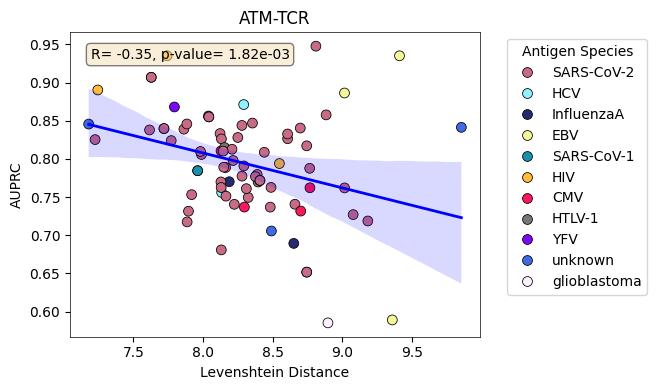

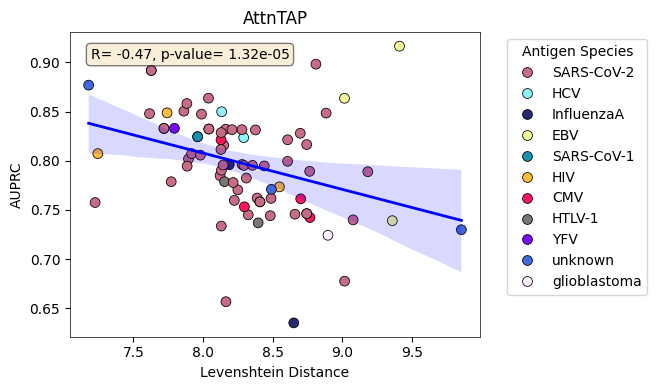

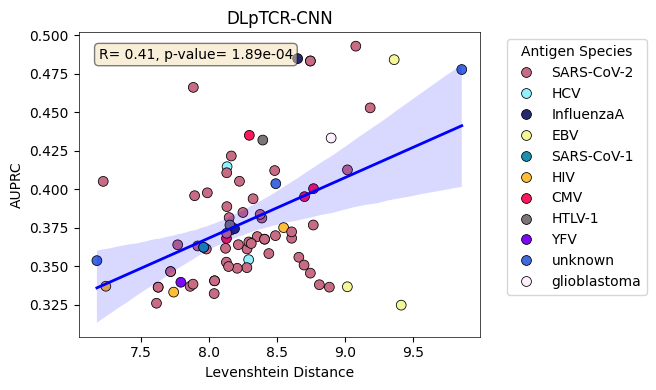

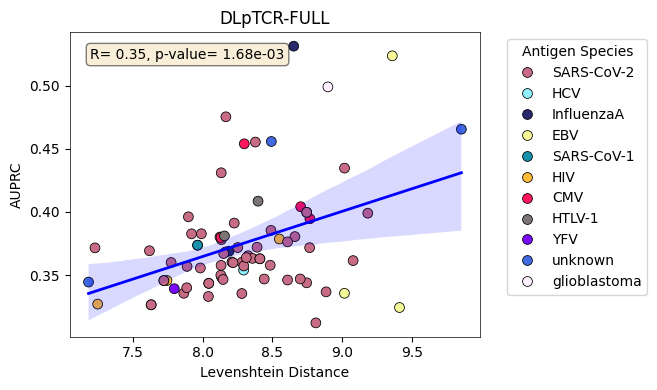

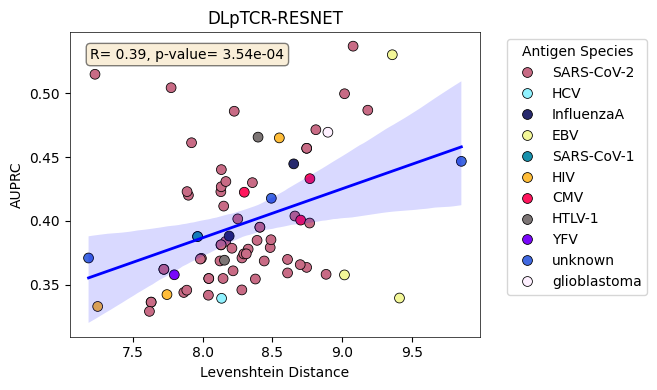

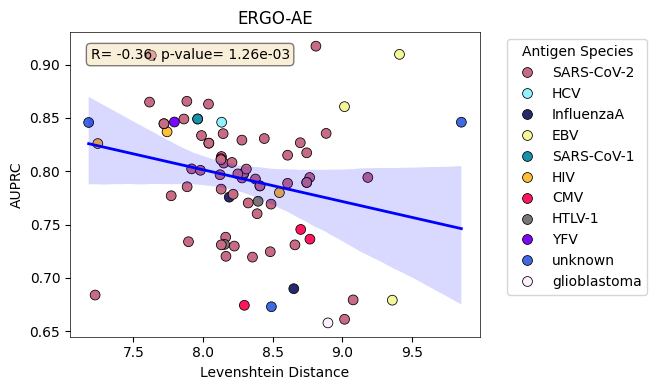

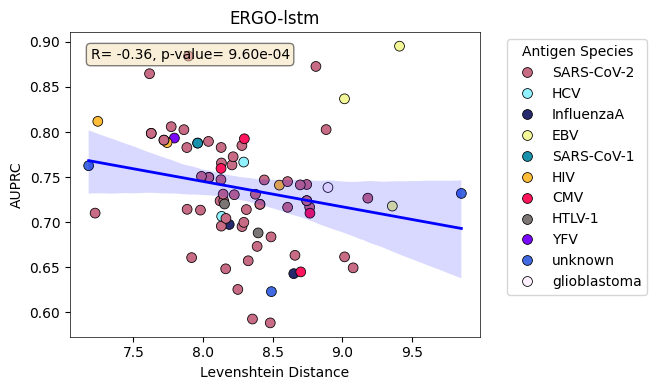

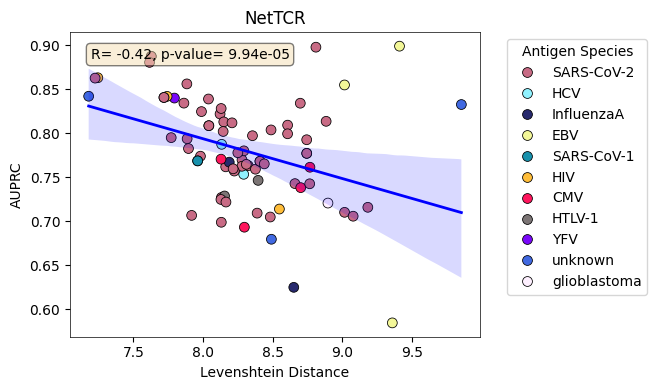

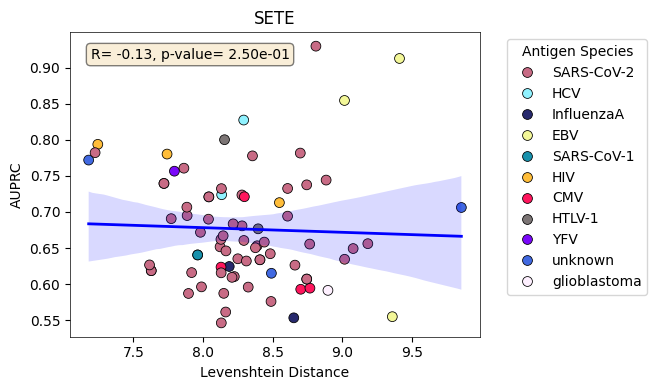

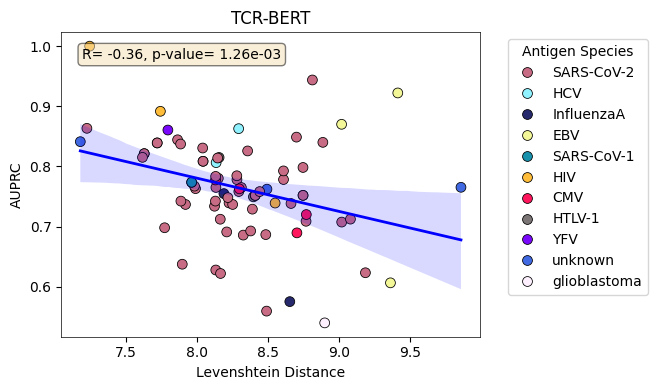

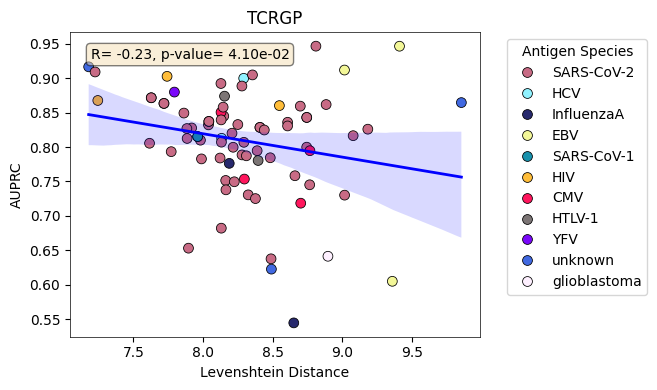

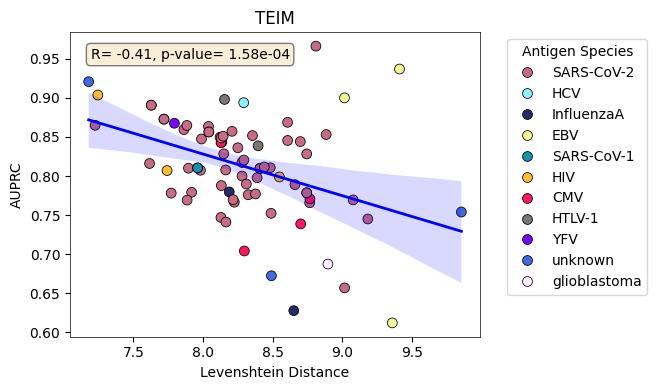

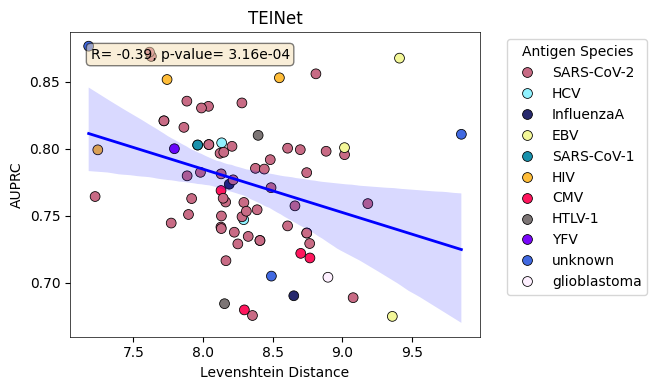

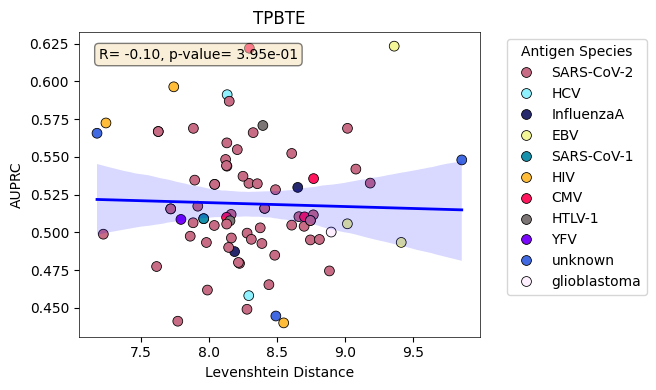

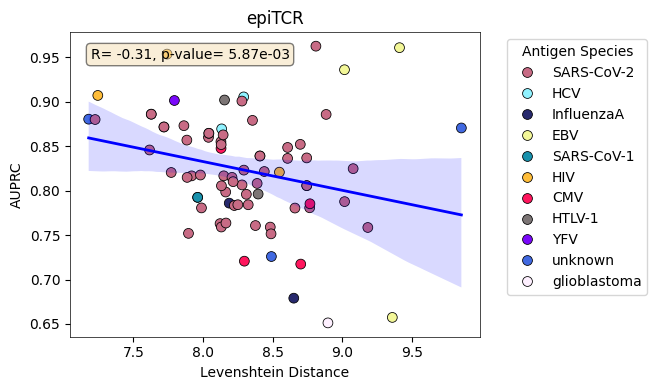

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from Levenshtein import distance
import itertools

Dean=pd.read_csv("./pair50/healthy/1_1_1train.csv")
Dean_pos=Dean[Dean['Affinity']==1]
Dean_pos=Dean_pos[['CDR3B','Epitope']]
def average_levenshtein(group):
    sequences = group['CDR3B'].tolist()
    distances = [distance(a, b) for a, b in itertools.combinations(sequences, 2)]
    if len(distances) == 0:
        return 0  
    return sum(distances) / len(distances)

average_distances = Dean_pos.groupby('Epitope').apply(average_levenshtein)
average_distances_df = average_distances.reset_index()
average_distances_df.columns = ['Epitope', 'Average Levenshtein Distance']
average_distances_df.columns = ['Epitope', 'Distance']
all_data_dis=pd.merge(all_data, average_distances_df, on='Epitope', how='inner')  
antigen = pd.read_csv("./database/benchmark_dataset/raw_data/antigen_species.csv")
all_data_dis=pd.merge(all_data_dis, antigen, on='Epitope')
antigen_color_map = {
    'SARS-CoV-2': '#c86b85',
    'HCV': '#90f2ff',
    'InfluenzaA': '#27296d',
    'EBV': '#f3f798',
    'SARS-CoV-1': '#1891ac',
    'HIV': '#ffbd39',
    'CMV': '#ff165d',
    'HTLV-1': '#7c7575',
    'YFV': '#7a08fa',
    'unknown': '#4169E1',
    'glioblastoma': '#fef0ff'}

columns = all_data_dis.columns.difference(['Epitope','Distance'])
columns = columns.drop(['Unnamed: 0', 'antigen_species'])
all_data_dis['Distance'] = pd.to_numeric(all_data_dis['Distance'], errors='coerce')
for column in columns:
    all_data_dis[column] = pd.to_numeric(all_data_dis[column], errors='coerce')
    valid_data = all_data_dis.dropna(subset=['Distance', column])
    spearman_corr, spearman_p_value = spearmanr(valid_data[column], valid_data['Distance'])
    plt.figure(figsize=(5.5, 5))
    unique_species = valid_data['antigen_species'].unique()
    species_color_map = {species: antigen_color_map.get(species, '#000000') for species in unique_species}
    sns.scatterplot(x='Distance', y=column, hue='antigen_species', data=valid_data, 
                    palette=species_color_map, s=50, edgecolor="black")
    sns.regplot(x='Distance', y=column, data=valid_data, ci=95, scatter=False,
                line_kws={'color': 'blue', 'lw': 2})

    plt.xlabel('Levenshtein Distance')
    plt.ylabel('AUPRC')
    plt.title(column)

    textstr = (f'R= {spearman_corr:.2f}, p-value= {spearman_p_value:.2e}')
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.gca().text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
                   verticalalignment='top', bbox=props)
    plt.grid(False)
    plt.tight_layout()
    plt.legend(title='Antigen Species', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
    
    
    plt.show()

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from Levenshtein import distance
import itertools
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as mtick
from matplotlib.ticker import LinearLocator 

Dean = pd.read_csv("./pair50/healthy/1_1_1train.csv")
Dean_pos = Dean[Dean['Affinity'] == 1]
Dean_pos = Dean_pos[['CDR3B', 'Epitope']]

def average_levenshtein(group):
    sequences = group['CDR3B'].tolist()
    distances = [distance(a, b) for a, b in itertools.combinations(sequences, 2)]
    if len(distances) == 0:
        return 0  
    return sum(distances) / len(distances)

average_distances = Dean_pos.groupby('Epitope').apply(average_levenshtein)
average_distances_df = average_distances.reset_index()
average_distances_df.columns = ['Epitope', 'Distance']

all_data_dis = pd.merge(all_data, average_distances_df, on='Epitope', how='inner')
antigen = pd.read_csv("./raw_data/antigen_species.csv")
all_data_dis = pd.merge(all_data_dis, antigen, on='Epitope')

pdf_filename = "./All_results/fig/fig4/D_TCR_similarity_number_AUPRC.pdf"
with PdfPages(pdf_filename) as pdf:
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['font.size'] = 12  
    plt.rcParams['axes.titlesize'] = 12  
    plt.rcParams['axes.labelsize'] = 12  
    plt.rcParams['xtick.labelsize'] = 12 
    plt.rcParams['ytick.labelsize'] = 12 
    plt.rcParams['legend.fontsize'] = 12 

    antigen_color_map = {
        'SARS-CoV-2': '#c86b85',
        'HCV': '#90f2ff',
        'InfluenzaA': '#27296d',
        'EBV': '#f3f798',
        'SARS-CoV-1': '#1891ac',
        'HIV': '#ffbd39',
        'CMV': '#ff165d',
        'HTLV-1': '#7c7575',
        'YFV': '#7a08fa',
        'unknown': '#4169E1',
        'glioblastoma': '#fef0ff'}

    columns = all_data_dis.columns.difference(['Epitope','Distance'])
    columns = columns.drop(['Unnamed: 0', 'antigen_species'])
    all_data_dis['Distance'] = pd.to_numeric(all_data_dis['Distance'], errors='coerce')
    
    for column in columns:
        all_data_dis[column] = pd.to_numeric(all_data_dis[column], errors='coerce')
        valid_data = all_data_dis.dropna(subset=['Distance', column])
        spearman_corr, spearman_p_value = spearmanr(valid_data[column], valid_data['Distance'])
        
        plt.figure(figsize=(6.5, 4))
        unique_species = valid_data['antigen_species'].unique()
        species_color_map = {species: antigen_color_map.get(species, '#000000') for species in unique_species}
        
        sns.scatterplot(x='Distance', y=column, hue='antigen_species', data=valid_data, 
                        palette=species_color_map, s=50, edgecolor="black")
        
        sns.regplot(x='Distance', y=column, data=valid_data, ci=95, scatter=False,
                    line_kws={'color': 'blue', 'lw': 2})
        plt.gca().yaxis.set_major_locator(LinearLocator(numticks=6))
        plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))

        plt.xlabel('Levenshtein Distance')
        plt.ylabel('AUPRC')
        plt.title(column)

        textstr = (f'R= {spearman_corr:.2f}, p-value= {spearman_p_value:.2e}')
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        plt.gca().text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
                       verticalalignment='top', bbox=props)
        plt.grid(False)
        plt.tight_layout()
        plt.legend(title='Antigen Species', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
        plt.tight_layout()
        pdf.savefig()
        plt.close()
        
print(f"All plots have been saved to {pdf_filename}")


/tmp/ipykernel_35465/1602871204.py:11: DtypeWarning: Columns (5,6,7,8,10) have mixed types. Specify dtype option on import or set low_memory=False.
  Dean = pd.read_csv("./database/benchmark_dataset/10cross_validation/pair50/healthy/1_1_1train.csv")


All plots have been saved to ./All_results/fig/fig4/D_TCR_similarity_number_AUPRC.pdf
